In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.15.0


In [3]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

/home/arys/miniconda3/envs/DEV_IA/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Tokenizer

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

## Padding and Truncating Sequences

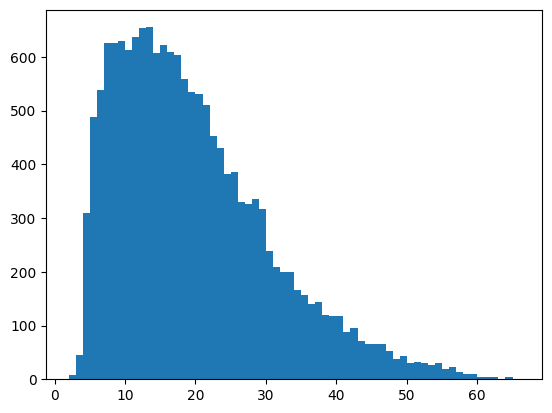

In [11]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [12]:
maxlen = 50

In [13]:
from keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequence(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return padded

In [16]:
padded_train = get_sequence(tokenizer, tweets)

In [17]:
padded_train


array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]], dtype=int32)

## Preparing the labels

In [22]:
classes_index = set(labels)

In [23]:
classes_index

{0, 1, 2, 3, 4, 5}

In [24]:
classes = {'sadness', 'joy', 'love', 'anger', 'fear', 'surprise'}

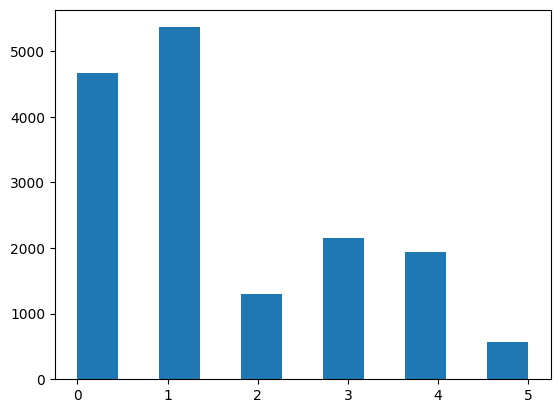

In [26]:
plt.hist(labels, bins=11)
plt.show()

In [29]:
classes_to_index = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
index_to_classes = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [38]:
names_to_ids = lambda l: np.array([index_to_classes.get(x) for x in l])

In [39]:
train_labels = names_to_ids(labels)

In [42]:
labels[0]

0

## creating the model

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),
    tf.keras.layers.Dense(units=6, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [54]:
model.summary(
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the model

In [71]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequence(tokenizer, val_tweets)
#val_labels = val_labels = names_to_ids(val_labels)

In [72]:
val_tweets[0], type(val_labels[0])


('im feeling quite sad and sorry for myself but ill snap out of it soon', int)

In [100]:
print(type(padded_train[0][0]))
print(type(val_seq[0][0]))
print(type(labels[0]))
print(type(val_labels[0]))
ds_train_x = padded_train
ds_train_y = np.array(labels)
ds_val_x = val_seq
ds_val_y = np.array(val_labels)


<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'int'>
<class 'int'>


In [90]:
ds_train = tf.data.Dataset.from_tensor_slices((padded_train, labels))
ds_test = tf.data.Dataset.from_tensor_slices((val_seq, val_labels))

In [94]:
labels

[0,
 0,
 3,
 2,
 3,
 0,
 5,
 4,
 1,
 2,
 0,
 1,
 3,
 0,
 1,
 1,
 0,
 0,
 0,
 4,
 3,
 4,
 1,
 1,
 3,
 0,
 0,
 0,
 3,
 1,
 1,
 4,
 5,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 3,
 1,
 0,
 3,
 4,
 1,
 0,
 0,
 5,
 1,
 1,
 1,
 2,
 4,
 4,
 5,
 3,
 3,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 3,
 0,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 0,
 4,
 2,
 3,
 0,
 3,
 2,
 0,
 1,
 1,
 0,
 3,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 4,
 4,
 4,
 0,
 2,
 1,
 1,
 2,
 4,
 5,
 1,
 1,
 1,
 1,
 3,
 4,
 1,
 3,
 2,
 3,
 0,
 1,
 0,
 3,
 1,
 5,
 0,
 3,
 3,
 0,
 1,
 4,
 1,
 1,
 4,
 0,
 5,
 5,
 1,
 3,
 4,
 3,
 0,
 3,
 0,
 4,
 0,
 1,
 5,
 4,
 1,
 3,
 1,
 3,
 1,
 4,
 4,
 0,
 1,
 1,
 0,
 5,
 1,
 4,
 1,
 0,
 1,
 1,
 1,
 4,
 1,
 5,
 1,
 3,
 0,
 0,
 1,
 3,
 0,
 1,
 1,
 5,
 1,
 4,
 1,
 4,
 0,
 4,
 2,
 0,
 4,
 2,
 0,
 0,
 3,
 1,
 2,
 3,
 0,
 5,
 3,
 1,
 0,
 3,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 3,
 5,
 1,
 3,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,


In [92]:
padded_train

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]], dtype=int32)

In [96]:
len(val_labels)

2000

In [93]:
val_seq

array([[ 17,   8, 157, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0],
       ...,
       [  2,   3,  79, ...,   0,   0,   0],
       [  2, 395,   3, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0]], dtype=int32)

In [101]:
h = model.fit(
    ds_train_x, ds_train_y,
    validation_data=(ds_val_x, ds_val_y),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20


2024-03-21 11:43:20.371381: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-21 11:43:20.544931: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f35f862f700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 11:43:20.544977: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-21 11:43:20.567577: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711017800.692052  547116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 23s 40ms/step - loss: 1.3398 - accuracy: 0.4755 - val_loss: 0.8908 - val_accuracy: 0.6770
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.6759 - accuracy: 0.7581 - val_loss: 0.6041 - val_accuracy: 0.8105
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.4205 - accuracy: 0.8637 - val_loss: 0.4847 - val_accuracy: 0.8310
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3029 - accuracy: 0.8986 - val_loss: 0.4872 - val_accuracy: 0.8370
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2332 - accuracy: 0.9258 - val_loss: 0.4454 - val_accuracy: 0.8655
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2019 - accuracy: 0.9391 - val_loss: 0.4406 - val_accuracy: 0.8660
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1379 - accuracy: 0.9578 - val_loss: 0.4484 - val_accuracy: 0.8770
Epo

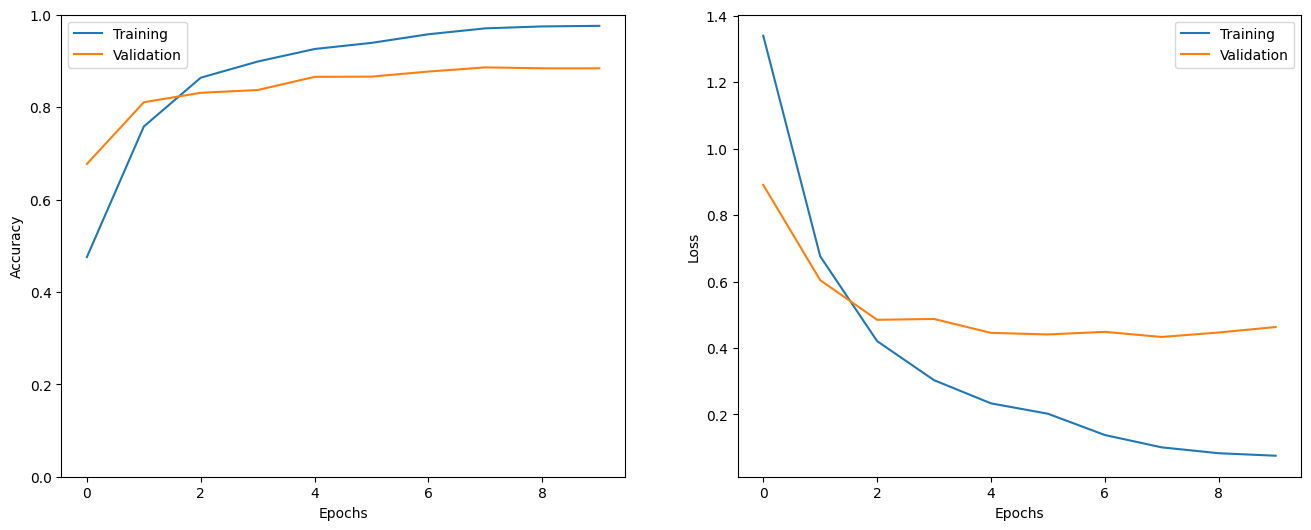

In [102]:
show_history(h)

In [106]:
test_tweets, test_labels = get_tweet(test)

In [108]:
test_seq = get_sequence(tokenizer, test_tweets)
test_labels = np.array(test_labels)

In [109]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4657 - accuracy: 0.8795


In [110]:
i = random.randint(0, len(test_labels) - 1)

In [111]:
print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_classes[test_labels[i]])

Sentence:  i feel that it is of vital importance that those who care about me know this stuff
Emotion:  joy


In [112]:
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]

1/1 [==============================] - 1s 1s/step
